## Brooklyn

In [1]:
# import data
%matplotlib inline
import pandas as pd
import numpy as np
brooklyn_data = pd.read_excel('brooklyn2018.xls', thousands=',')
# clean data
brooklyn_data = brooklyn_data[brooklyn_data['SALE PRICE'] > 10]
brooklyn_data = brooklyn_data[brooklyn_data['LAND SQUARE FEET'] != 0]
brooklyn_data = brooklyn_data[brooklyn_data['GROSS SQUARE FEET'] != 0]
# brooklyn_data[ind_list].head()

In [2]:
# create unit price variable
brooklyn_data['UNIT PRICE'] = brooklyn_data['SALE PRICE']/brooklyn_data['LAND SQUARE FEET']

In [3]:
len(brooklyn_data)

7708

In [4]:
brooklyn_data.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING CLASS AT PRESENT', 'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE',
       'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS',
       'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE',
       'SALE PRICE', 'SALE DATE', 'UNIT PRICE'],
      dtype='object')

In [5]:
# randomly select data
brooklyn_select = brooklyn_data.sample(n = 1000)

In [6]:
address_list = brooklyn_select['ADDRESS'].tolist()

In [7]:
#import googlemaps
#gmaps = googlemaps.Client(key='XXXXXXXXXX')

In [8]:
def address_refine(x):
    y = x.strip() + ", Brooklyn, NY"
    return y

In [9]:
address_list_new = list(map(address_refine, address_list))

In [10]:
result_list = []
for a in address_list_new:
    geocode_result = gmaps.geocode(a)
    result_list.append(geocode_result)
    #print(len(geocode_result))

In [11]:
lat_list = []
lng_list = []

for r in result_list:
    lat = r[0]['geometry']['location']['lat']
    lat_list.append(lat)
    lng = r[0]['geometry']['location']['lng']
    lng_list.append(lng)

In [12]:
len(lat_list)
len(lng_list)

1000

In [14]:
df = pd.DataFrame({
    'address': address_list,
    'address_new': address_list_new,
    'unit price': brooklyn_select['UNIT PRICE'],
    'longitude':lng_list,
    'latitude':lat_list})

In [15]:
from shapely.geometry import Point
import geopandas as gpd
geometry_list = [Point(i) for i in list(zip(df['longitude'], df['latitude']))]

In [16]:
# create GeoDataFrame 
gdf = gpd.GeoDataFrame(data = df, crs = 'epsg:4326', geometry = geometry_list)

In [17]:
gdf.crs

'epsg:4326'

In [18]:
# project
from pyproj import Proj, transform
def proj(z):
    inProj = Proj(init='epsg:4326')
    outProj = Proj(init='epsg:32618')
    x1,y1 = z[0], z[1]
    x2,y2 = transform(inProj,outProj,x1,y1)
    return((x2,y2))

In [19]:
geometry_list = [Point(proj(i)) for i in list(zip(df['longitude'], df['latitude']))]
gdf_proj = gpd.GeoDataFrame(data = df, crs = 'epsg:32618', geometry = geometry_list)
gdf_proj.to_file('brooklyn_data_proj.shp')

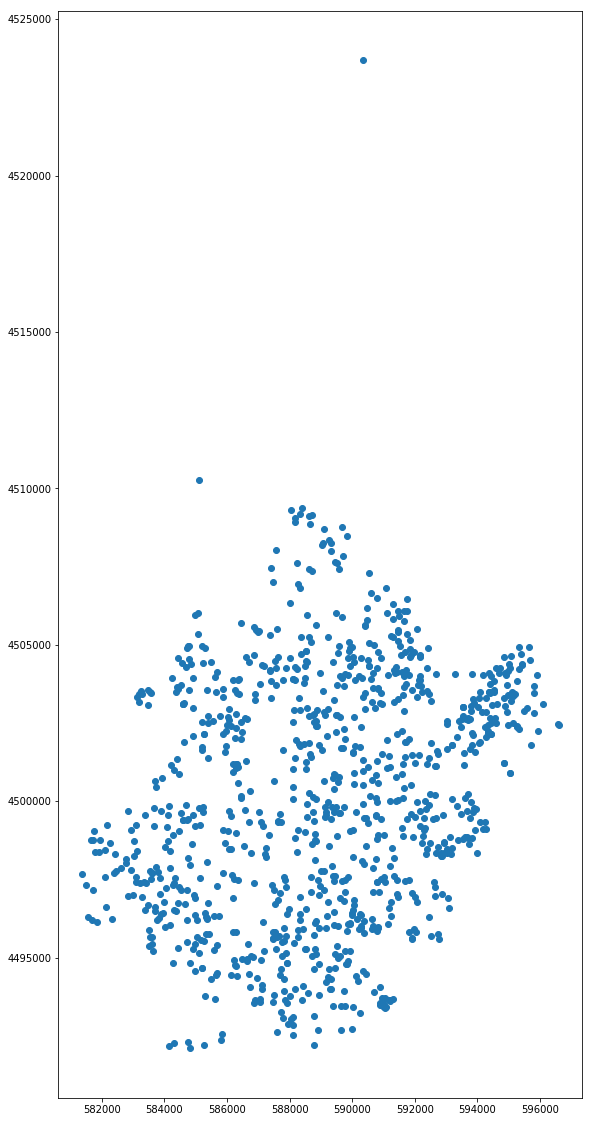

In [20]:
gdf_proj.plot(figsize=(10,20),legend_kwds={'title': 'Brooklyn',
                                           'title_fontsize': 10})

### Regression Model

In [21]:
# dependent variable
dep_var = ['UNIT PRICE']
y = brooklyn_select[dep_var].values.reshape((-1,1))


# independent variables
ind_list = ['BLOCK', 'LOT', 'ZIP CODE',
       'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS', 
       'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT', 'TAX CLASS AT TIME OF SALE']
for i in ind_list:
    brooklyn_select[i] = pd.to_numeric(brooklyn_select[i])
X = brooklyn_select[ind_list].values

In [22]:
# normalize
from sklearn import preprocessing
X = preprocessing.scale(X)
y = preprocessing.scale(y)

In [23]:
type(y), y.shape

(numpy.ndarray, (1000, 1))

In [24]:
type(X), X.shape 

(numpy.ndarray, (1000, 10))

In [25]:
# coordinates
coords = [(z.x, z.y) for z in gdf['geometry']]
len(coords)

1000

### GWR

In [1]:
#import pysal as ps
# select bandwith
#gwr_selector = ps.model.mgwr.sel_bw.Sel_BW(coords, y, X)
#gwr_bw = gwr_selector.search()

In [27]:
gwr_bw

139.0

In [28]:
# build model
model = ps.model.mgwr.gwr.GWR(coords,y, X, bw=139.0, fixed=False, kernel='bisquare')
gwr_results = model.fit()

In [29]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                1000
Number of covariates:                                                    11

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            753.266
Log-likelihood:                                                   -1277.270
AIC:                                                               2576.540
AICc:                                                              2576.756
BIC:                                                              -6078.504
R2:                                                                   0.247
Adj. R2:                                                              0.239

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

### GWR Plot

In [30]:
gdf_proj.columns

Index(['address', 'address_new', 'unit price', 'longitude', 'latitude',
       'geometry'],
      dtype='object')

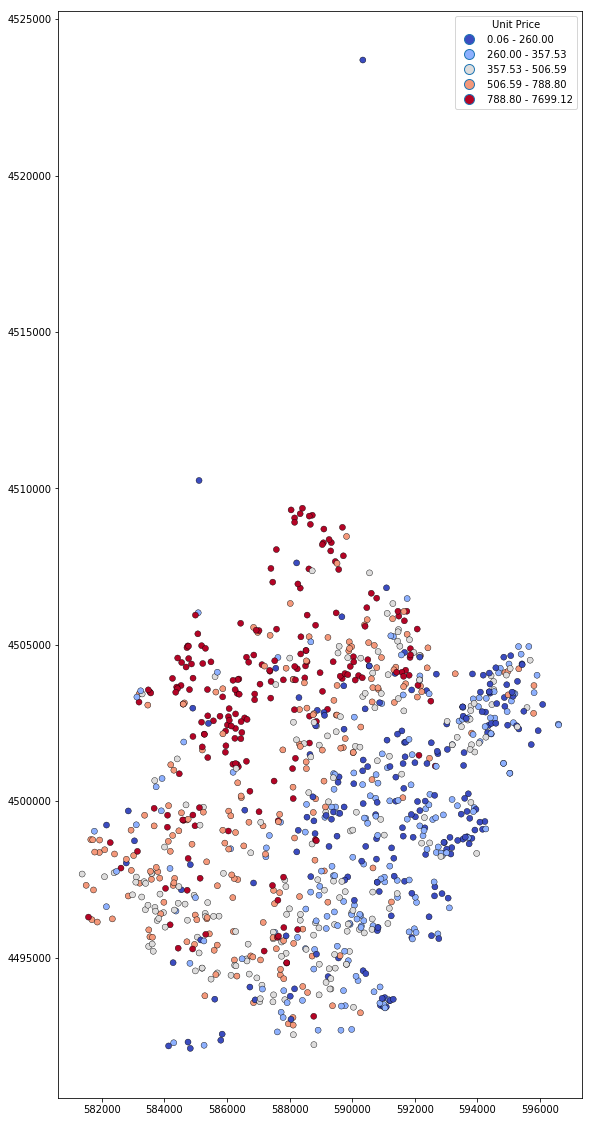

In [31]:
gdf_proj.plot(column = 'unit price', cmap = 'coolwarm', 
                 scheme='quantiles', k = 5,
                 edgecolor='black', linewidth=0.4,
                 figsize=(20,20),
                 legend = True, legend_kwds={'frameon': True, 
                                           'loc': 'upper right',
                                           'title': 'Unit Price',
                                           'title_fontsize': 10,
                                           'fontsize': 10})

In [32]:
for v in ind_list:
    gdf_proj[v] = brooklyn_select[v]

In [33]:
gdf_proj.columns[-10:]

Index(['BLOCK', 'LOT', 'ZIP CODE', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS',
       'TOTAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE'],
      dtype='object')

/anaconda3/lib/python3.7/site-packages/mapclassify/classifiers.py:95: UserWarning: Warning: Not enough unique values in array to form k classes
  UserWarning)
/anaconda3/lib/python3.7/site-packages/mapclassify/classifiers.py:96: UserWarning: Warning: setting k to 4
  Warn('Warning: setting k to %d' % k_q, UserWarning)
/anaconda3/lib/python3.7/site-packages/mapclassify/classifiers.py:95: UserWarning: Warning: Not enough unique values in array to form k classes
  UserWarning)
/anaconda3/lib/python3.7/site-packages/mapclassify/classifiers.py:96: UserWarning: Warning: setting k to 2
  Warn('Warning: setting k to %d' % k_q, UserWarning)
/anaconda3/lib/python3.7/site-packages/mapclassify/classifiers.py:95: UserWarning: Warning: Not enough unique values in array to form k classes
  UserWarning)
/anaconda3/lib/python3.7/site-packages/mapclassify/classifiers.py:96: UserWarning: Warning: setting k to 4
  Warn('Warning: setting k to %d' % k_q, UserWarning)
/anaconda3/lib/python3.7/site-packages/m

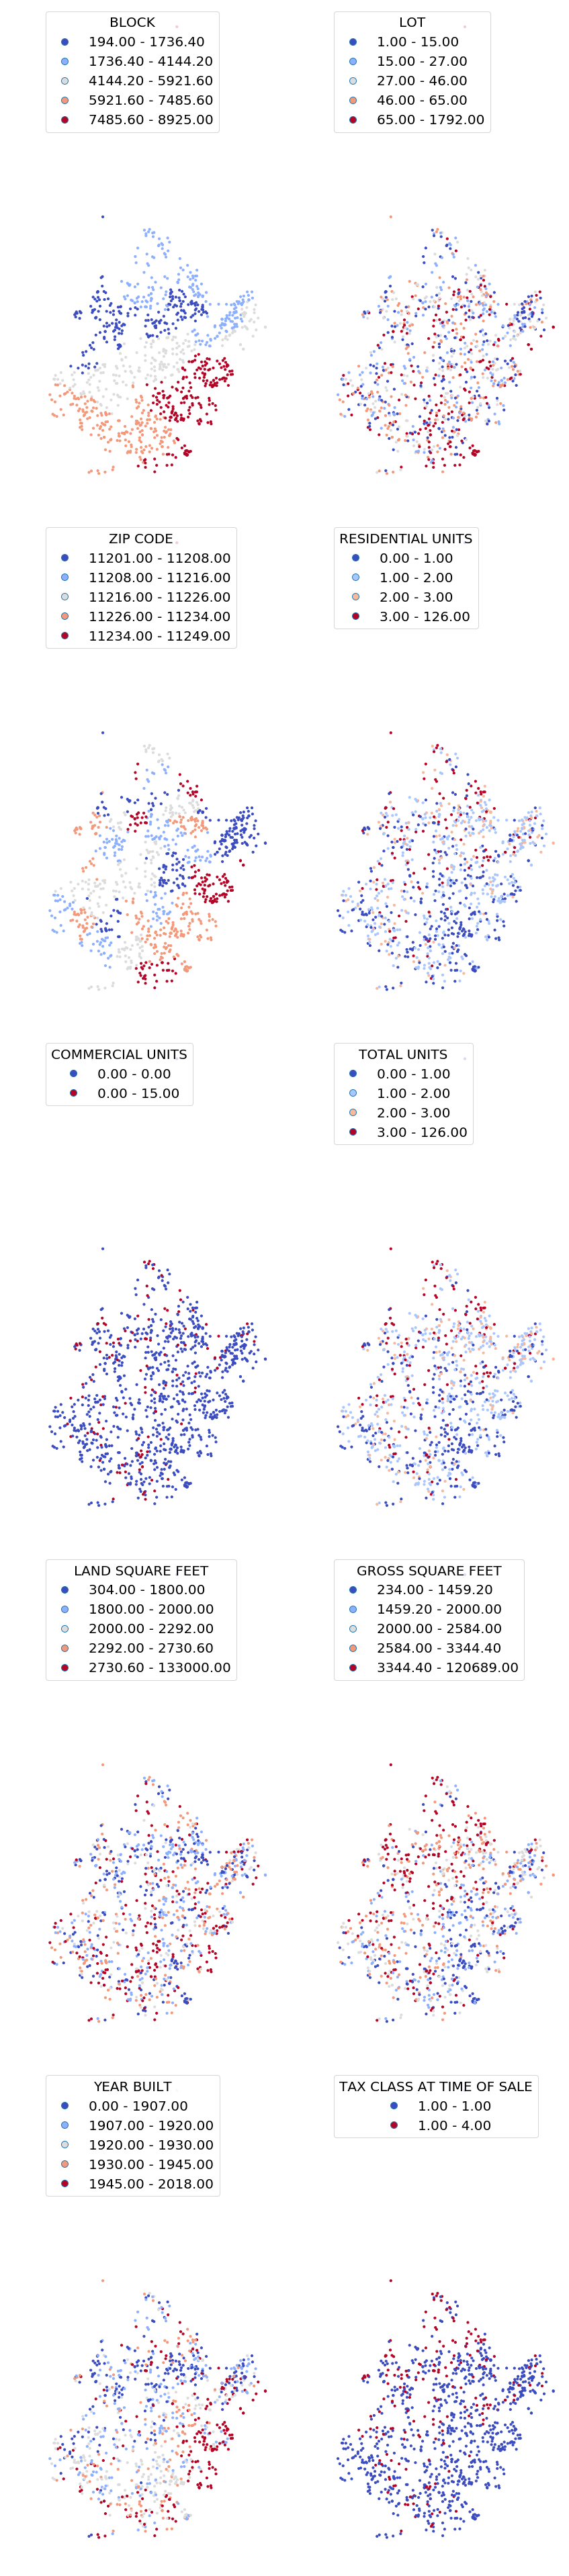

In [67]:
import matplotlib.pyplot as plt
# create a variable list to loop over
var_list = gdf_proj.columns[-10:].tolist()

# prep plot and add axes
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(15,70))

# start for loop
for v in range(len(var_list)):
    
    # take the vth variable
    var = var_list[v]

    # plot GWR parameters
    gdf_proj.plot(ax = ax[v//2, v%2], column = var, cmap='coolwarm', 
             scheme = 'quantiles', k = 5,
             markersize = 10,
             legend = True, legend_kwds={'frameon': True, 
                                           'loc': 'upper left',
                                           'title': var,
                                           'title_fontsize': 20,
                                           'fontsize': 20})
    ax[v//2, v%2].axis('off');
    
plt.subplots_adjust(hspace=0.05,
                    wspace=0.05)

## Manhattan

In [35]:
# import data
manhattan_data = pd.read_excel('manhattan2018.xls', thousands=',')
# clean data
manhattan_data = manhattan_data[manhattan_data['SALE PRICE'] > 10]
manhattan_data = manhattan_data[manhattan_data['LAND SQUARE FEET'] != 0]
manhattan_data = manhattan_data[manhattan_data['GROSS SQUARE FEET'] != 0]
# brooklyn_data[ind_list].head()

In [36]:
# create unit price variable
manhattan_data['UNIT PRICE'] = manhattan_data['SALE PRICE']/manhattan_data['LAND SQUARE FEET']

In [37]:
len(manhattan_data)

970

In [38]:
# randomly select data
manhattan_select = manhattan_data.sample(n = 400)

In [39]:
address_list1 = manhattan_select['ADDRESS'].tolist()

In [40]:
manhattan_data.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING CLASS AT PRESENT', 'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE',
       'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS',
       'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE',
       'SALE PRICE', 'SALE DATE', 'UNIT PRICE'],
      dtype='object')

In [41]:
def address_refine1(x):
    y = x.strip() + ", Manhattan, NY"
    return y

In [42]:
address_list_new1 = list(map(address_refine1, address_list1))

In [43]:
result_list1 = []
for a in address_list_new1:
    geocode_result1 = gmaps.geocode(a)
    result_list1.append(geocode_result1)
    #print(len(geocode_result))

In [44]:
lat_list1 = []
lng_list1 = []

for r in result_list1:
    lat = r[0]['geometry']['location']['lat']
    lat_list1.append(lat)
    lng = r[0]['geometry']['location']['lng']
    lng_list1.append(lng)

In [45]:
len(lat_list1)
len(lng_list1)

400

In [46]:
df1 = pd.DataFrame({
    'address': address_list1,
    'address_new': address_list_new1,
    'unit price': manhattan_select['UNIT PRICE'],
    'longitude':lng_list1,
    'latitude':lat_list1})

In [47]:
geometry_list1 = [Point(i) for i in list(zip(df1['longitude'], df1['latitude']))]

In [48]:
# create GeoDataFrame 
gdf1 = gpd.GeoDataFrame(data = df1, crs = 'epsg:4326', geometry = geometry_list1)

In [49]:
gdf1.crs

'epsg:4326'

In [50]:
geometry_list1 = [Point(proj(i)) for i in list(zip(df1['longitude'], df1['latitude']))]
gdf_proj1 = gpd.GeoDataFrame(data = df1, crs = 'epsg:32618', geometry = geometry_list1)
gdf_proj1.to_file('manhattan_data_proj.shp')
# gdf_proj.plot(figsize=(10,20))

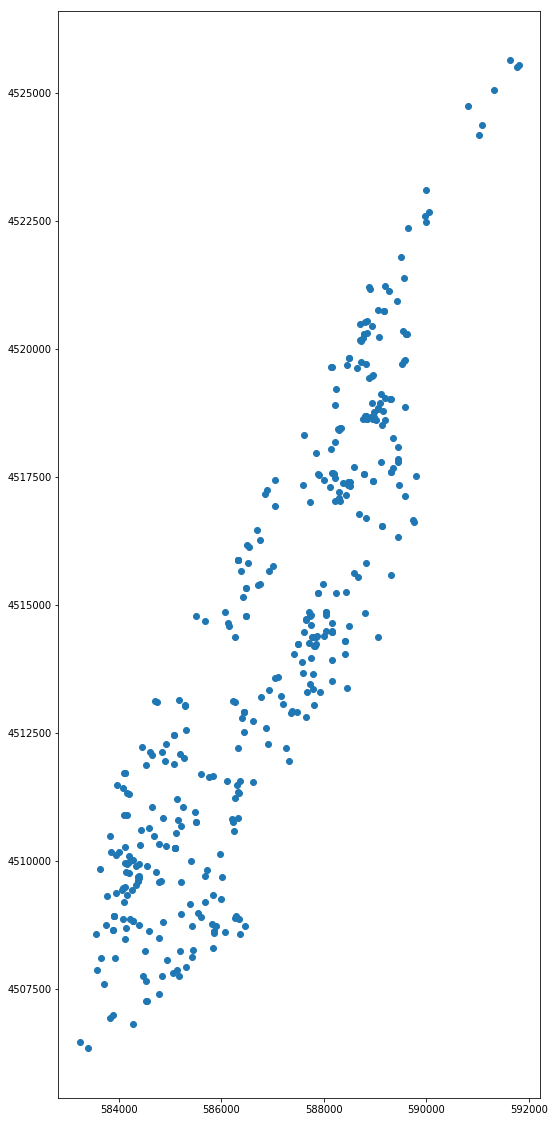

In [51]:
gdf_proj1.plot(figsize=(10,20))

### Regression Model

In [52]:
# dependent variable
dep_var = ['UNIT PRICE']
y1 = manhattan_select[dep_var].values.reshape((-1,1))


# independent variables
ind_list = ['BLOCK', 'LOT', 'ZIP CODE',
       'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS', 
       'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT', 'TAX CLASS AT TIME OF SALE']
for i in ind_list:
    manhattan_select[i] = pd.to_numeric(manhattan_select[i])
X1 = manhattan_select[ind_list].values

In [53]:
# normalize
from sklearn import preprocessing
X1 = preprocessing.scale(X1)
y1 = preprocessing.scale(y1)

In [54]:
len(X1)

400

In [55]:
# coordinates
coords1 = [(z.x, z.y) for z in gdf1['geometry']]

In [2]:
# select bandwith
#gwr_selector1 = ps.model.mgwr.sel_bw.Sel_BW(coords1, y1, X1)
#gwr_bw1 = gwr_selector1.search()

In [57]:
gwr_bw1

222.0

In [58]:
model1 = ps.model.mgwr.gwr.GWR(coords1,y1, X1, bw=222.0, fixed=False, kernel='bisquare')
gwr_results1 = model1.fit()

In [59]:
gwr_results1.summary()

Model type                                                         Gaussian
Number of observations:                                                 400
Number of covariates:                                                    11

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            343.597
Log-likelihood:                                                    -537.176
AIC:                                                               1096.352
AICc:                                                              1094.881
BIC:                                                              -1987.083
R2:                                                                   0.141
Adj. R2:                                                              0.119

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

### GWR Plot

In [60]:
gdf_proj1.columns

Index(['address', 'address_new', 'unit price', 'longitude', 'latitude',
       'geometry'],
      dtype='object')

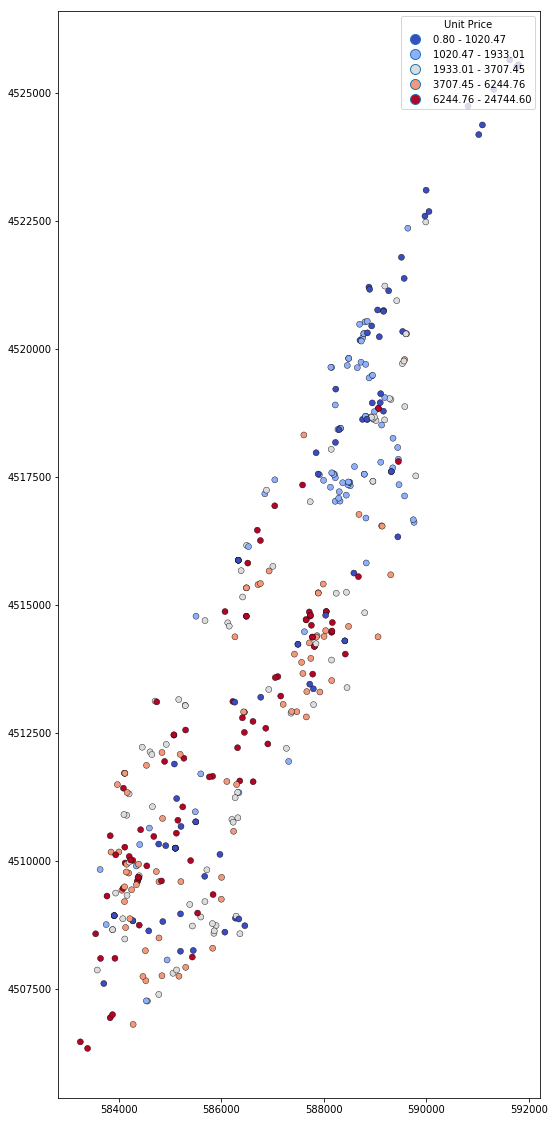

In [61]:
gdf_proj1.plot(column = 'unit price', cmap = 'coolwarm', 
                 scheme='quantiles', k = 5,
                 edgecolor='black', linewidth=0.4,
                 figsize=(20,20),
                 legend = True, legend_kwds={'frameon': True, 
                                           'loc': 'upper right',
                                           'title': 'Unit Price',
                                           'title_fontsize': 10,
                                           'fontsize': 10})

In [62]:
for v in ind_list:
    gdf_proj1[v] = manhattan_select[v]

In [63]:
gdf_proj1.columns[-10:]

Index(['BLOCK', 'LOT', 'ZIP CODE', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS',
       'TOTAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE'],
      dtype='object')

/anaconda3/lib/python3.7/site-packages/mapclassify/classifiers.py:95: UserWarning: Warning: Not enough unique values in array to form k classes
  UserWarning)
/anaconda3/lib/python3.7/site-packages/mapclassify/classifiers.py:96: UserWarning: Warning: setting k to 4
  Warn('Warning: setting k to %d' % k_q, UserWarning)
/anaconda3/lib/python3.7/site-packages/mapclassify/classifiers.py:95: UserWarning: Warning: Not enough unique values in array to form k classes
  UserWarning)
/anaconda3/lib/python3.7/site-packages/mapclassify/classifiers.py:96: UserWarning: Warning: setting k to 3
  Warn('Warning: setting k to %d' % k_q, UserWarning)


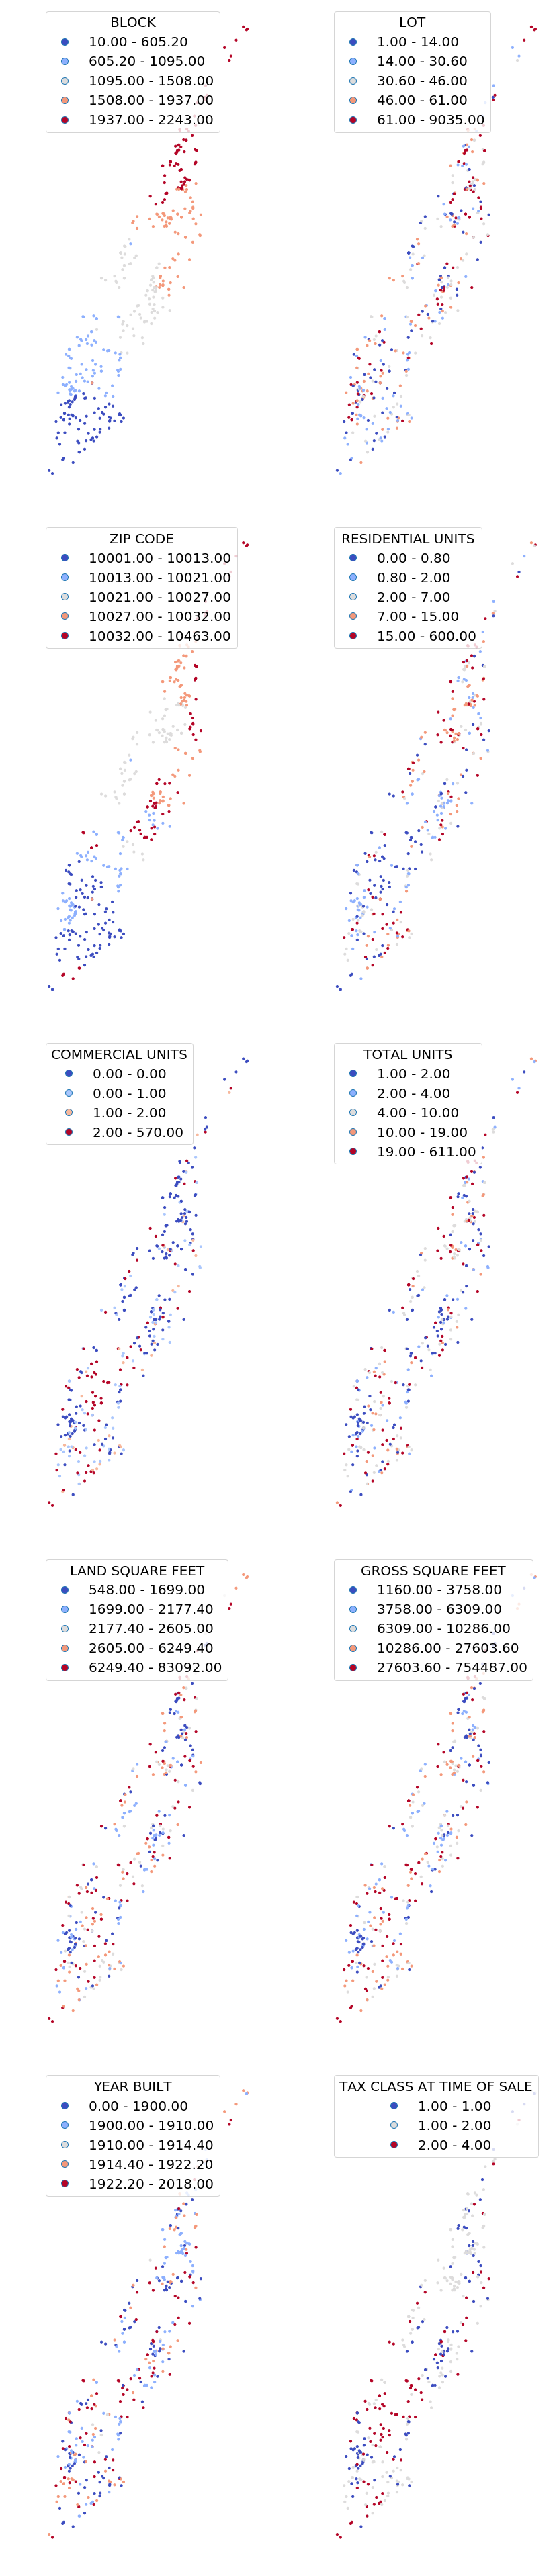

In [66]:
# create a variable list to loop over
var_list1 = gdf_proj1.columns[-10:].tolist()

# prep plot and add axes
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(15,70))

# start for loop
for v in range(len(var_list)):
    
    # take the vth variable
    var = var_list[v]

    # plot GWR parameters
    gdf_proj1.plot(ax = ax[v//2, v%2], column = var, cmap='coolwarm', 
             scheme = 'quantiles', k = 5,
             markersize = 10,
             legend = True, legend_kwds={'frameon': True, 
                                           'loc': 'upper left',
                                           'title': var,
                                           'title_fontsize': 20,
                                           'fontsize': 20})
    ax[v//2, v%2].axis('off');
    
plt.subplots_adjust(hspace=0.05,
                    wspace=0.05)